# Max Regression

A demo of the toy max-regression problem from the paper. These models learn to approximate the largest number in the given set, regardless of the order presented.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import tf_utils as tfu

import settransformer as stf

In [3]:
strategy = tfu.strategy.gpu(0, use_dynamic_memory=True)

2022-07-24 15:39:42.608610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:39:42.608926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:39:42.617741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:39:42.618066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:39:42.618356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [4]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    return x, y # (batch_size, length)

In [5]:
x, y = gen_data(3, 5)

In [6]:
print(x.shape, y.shape)

(3, 5) (3,)


In [7]:
x

array([[98, 61, 46, 44, 91],
       [90, 14, 88, 87, 31],
       [71, 17, 47, 38, 60]])

In [8]:
y

array([98, 90, 71])

---
## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [9]:
def create_model(
    embed_dim=64,
    num_heads=4,
    stack=2,
    use_layernorm=False,
    pre_layernorm=False,
    use_keras_mha=False # Use Keras' MHA implementation over the traditional Vaswani implementation
):
    y = x = keras.layers.Input((None,))
    y = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(y)
    y = keras.layers.Dense(embed_dim)(y)
    for _ in range(stack):
        y = stf.SetAttentionBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                use_layernorm=use_layernorm,
                pre_layernorm=pre_layernorm,
                use_keras_mha=use_keras_mha)(y)

    y = stf.PoolingByMultiHeadAttention(
            num_seeds=1,
            embed_dim=embed_dim,
            num_heads=1,
            use_layernorm=use_layernorm,
            pre_layernorm=pre_layernorm,
            use_keras_mha=use_keras_mha,
            is_final_block=True)(y)
    y = keras.layers.Dense(1)(y)
    y = keras.layers.Lambda(lambda x: tf.squeeze(x))(y)

    return keras.Model(x, y)

---
## Training (No Layernorm)

In [13]:
model = create_model(use_layernorm=False)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [14]:
x[:2]

array([[98, 61, 46, 44, 91],
       [90, 14, 88, 87, 31]])

In [15]:
model.predict(x[:2])

2022-07-24 15:40:16.707935: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([-123.048935, -107.52223 ], dtype=float32)

In [16]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [17]:
history_nln = model.fit(x, y, epochs=500, verbose=0)

In [18]:
x[:3]

array([[32, 18, 82, 83, 65],
       [51, 32, 22, 82, 28],
       [42, 56,  1,  2, 47]])

In [19]:
model.predict(x[:3])

array([82.357376, 81.30505 , 55.54624 ], dtype=float32)

---
## Training (Post-Layernorm)

In [21]:
model = create_model(use_layernorm=True, pre_layernorm=False)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [22]:
x[:2]

array([[32, 18, 82, 83, 65],
       [51, 32, 22, 82, 28]])

In [23]:
model.predict(x[:2])

array([-2.483456 , -2.5711875], dtype=float32)

In [24]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [25]:
history_post_ln = model.fit(x, y, epochs=500, verbose=0)

In [26]:
x[:3]

array([[ 1, 51, 91, 97, 91],
       [41, 42, 33, 82, 53],
       [15, 80, 33, 95, 33]])

In [27]:
model.predict(x[:3])

array([96.06869, 83.52949, 95.00522], dtype=float32)

---
## Training (Pre-Layernorm)

In [28]:
model = create_model(use_layernorm=True, pre_layernorm=True)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [29]:
x[:2]

array([[ 1, 51, 91, 97, 91],
       [41, 42, 33, 82, 53]])

In [30]:
model.predict(x[:2])

array([-1.484148 , -1.4941418], dtype=float32)

In [31]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [32]:
history_pre_ln = model.fit(x, y, epochs=500, verbose=0)

In [33]:
x[:3]

array([[14, 21,  4, 92, 39],
       [52,  6, 83, 53, 93],
       [46, 83, 11, 38, 78]])

In [34]:
model.predict(x[:3])

array([92.11145 , 93.088806, 83.09186 ], dtype=float32)

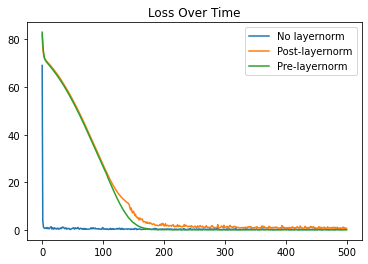

In [37]:
plt.plot(history_nln.history["loss"])
plt.plot(history_post_ln.history["loss"])
plt.plot(history_pre_ln.history["loss"])
plt.legend(["No layernorm", "Post-layernorm", "Pre-layernorm"])
plt.title("Loss Over Time")
plt.show()